# Docker BRATS results

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import os
import seaborn as sb
from pprint import pprint
%matplotlib inline

In [60]:
# set up the variables and environment
met = 'at'
# stupid switch for dumb experiments to make data pretty
stupid = True

#set baseline variables for export and stuff
res = 400 # dpi value for image export
form = 'png' #image format for matplotlib exports
filename = met + '_dice_scores.csv'
#rename colums to their 3 character IDs
candidates = {
        'aju' : 'tumor_istb_aj_class.nii',
        'aca' : 'data_data_prediction.nii.gz',
        'kch' : 'tumor_qtimlab_class.nii.gz',
        'ekr' : 'tumor_00000000_class.nii.gz',
        'aka' : 'tumor_kamleshp_class.nii.gz',
        'mag' : 'tumor_magnrbm_class.nii',
        'sse' : 'tumor_saras_tb_class.nii.gz',
        'rsa': 'tumor_gevaertlab_class.nii',
        'gwa' : 'brats_dc_brats2016_test_klhd_pat101_3.nii.gz',
        'ise' : 'tumor_brats2017_isensee_class.nii.gz',
        'mav' : 'majvote_fusion.nii.gz',
        'sim' : 'simple_fusion.nii.gz',
        'sim2': 'simple2_fusion.nii.gz',
        'none' : 'default'
    }

sseRep = {
    'brats2016_test_cbica_patAMQ_362' : 0,
    'brats2016_test_tcia_pat457_0079' : 0,
    'brats2016_test_cbica_patAOQ1_1' : 0
}
#invert the indices to assign the proper labels
inv_cand = {v: k for k, v in candidates.items()}

In [61]:
#import data
data = pandas.read_csv(filename)
#data

In [62]:
#preprocess data
def preprocessor(data, met):
    # remove every 2nd row (unnecessary column heads)
    clean = data.replace({'tumor_saras_tb_class.nii.gz' : sseRep})
    clean = clean.iloc[::2]
    # remove patient name column
    # clean = clean.drop('patient', axis=1)
    # rename columns to 3 digit ID
    clean = clean.rename(inv_cand, axis=1)
    # store csv
    clean.to_csv(met+'_clean.csv')
    # read a clean copy of the preprocessed csv again
    data = pandas.read_csv(met+'_clean.csv')
    # remove wrong row indices
    data = data.drop('Unnamed: 0', axis=1)
    return data

In [63]:
data = preprocessor(data, met)
# read a clean copy of the preprocessed csv again
# data = pandas.read_csv(met+'_clean.csv')
# remove wrong row indices
# data = data.drop('Unnamed: 0', axis=1)

In [64]:
data

,gwa,aca,mav,sim,ekr,ise,rsa,aju,aka,mag,kch,sse,patient
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,brats2016_test_klhd_pat101_3
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,brats2016_test_tcia_pat359_0001
2,0.685943,0.761251,0.827425,0.830731,0.827574,0.806789,0.861595,0.787136,0.769771,0.551247,0.787052,0.715416,brats2016_test_cbica_patANK_203
3,0.803452,0.836913,0.880313,0.881549,0.832440,0.903652,0.855402,0.835164,0.667192,0.722142,0.850545,0.778839,brats2016_test_tcia_pat174_0001
4,0.321267,0.046432,0.435138,0.449301,0.565926,0.473926,0.413598,0.382406,0.101538,0.000000,0.318308,0.115991,brats2016_test_cbica_patAKQ_1
5,0.395718,0.604756,0.684481,0.692938,0.586267,0.654025,0.332858,0.725488,0.482859,0.435163,0.504006,0.651715,brats2016_test_2013_pat0131_1
6,0.637980,0.671445,0.728405,0.733302,0.710730,0.716764,0.707157,0.656435,0.701974,0.527238,0.699224,0.727824,brats2016_test_tcia_pat271_0001
7,0.459069,0.620357,0.725073,0.736428,0.754321,0.732743,0.661793,0.733904,0.714694,0.588114,0.721304,0.734130,brats2016_test_cbica_patAMP_1
8,0.308344,0.559133,0.682335,0.682680,0.003326,0.607871,0.647654,0.609161,0.047792,0.572238,0.357639,0.654859,brats2016_test_cbica_patAAN_393
9,0.748065,0.766435,0.742502,0.762135,0.705583,0.752639,0.778975,0.627433,0.739931,0.439262,0.693811,0.636423,brats2016_test_tcia_pat500_0002


In [56]:
if stupid:
    beauty = data[data.mav > 0.3]
    data = beauty
beauty.describe()

,gwa,aca,mav,sim,ekr,ise,rsa,aju,aka,mag,kch,sse
count,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000
mean,0.609725,0.655564,0.736452,0.743284,0.688397,0.727525,0.660035,0.714203,0.597267,0.509362,0.705418,0.654461
std,0.174016,0.169035,0.115994,0.112098,0.179281,0.125454,0.193742,0.131267,0.199438,0.238444,0.155349,0.183905
min,0.000000,0.046432,0.340716,0.333333,0.003326,0.266384,0.000000,0.149670,0.047792,0.000000,0.014388,0.000000
25%,0.511447,0.604795,0.684765,0.688552,0.641031,0.663173,0.567834,0.656743,0.502807,0.407164,0.646436,0.568757
50%,0.652901,0.689354,0.751608,0.758413,0.733173,0.739042,0.724439,0.739268,0.656461,0.548484,0.736501,0.692047
75%,0.727325,0.764050,0.823605,0.826267,0.813126,0.823801,0.784366,0.810750,0.751474,0.679319,0.819587,0.791524
max,0.864293,0.893939,0.899601,0.900030,0.903979,0.907121,0.891112,0.893692,0.863044,0.882353,0.895067,0.887010


In [57]:
#sort the indices by their mean value and reorder the data frame for descending plotting
m = data.mean()
m_sorted = m.sort_values(ascending=False)
print('Mean values sorted:')
pprint(m_sorted)
print('\nMedian sorted:')
pprint(data.median().sort_values(ascending=False))
print('\nStandard deviation sorted:')
pprint(data.std().sort_values(ascending=True))
indices = m_sorted.keys()
# order dataframe by mean
indices = indices.tolist()
wt_ordered = data[indices]

Mean values sorted:
sim    0.743284
mav    0.736452
ise    0.727525
aju    0.714203
kch    0.705418
ekr    0.688397
rsa    0.660035
aca    0.655564
sse    0.654461
gwa    0.609725
aka    0.597267
mag    0.509362
dtype: float64

Median sorted:
sim    0.758413
mav    0.751608
aju    0.739268
ise    0.739042
kch    0.736501
ekr    0.733173
rsa    0.724439
sse    0.692047
aca    0.689354
aka    0.656461
gwa    0.652901
mag    0.548484
dtype: float64

Standard deviation sorted:
sim    0.112098
mav    0.115994
ise    0.125454
aju    0.131267
kch    0.155349
aca    0.169035
gwa    0.174016
ekr    0.179281
sse    0.183905
rsa    0.193742
aka    0.199438
mag    0.238444
dtype: float64


In [58]:
# export all metrics to a table 
metrics = pandas.concat([m_sorted, data.median(), data.std()], axis=1, sort=True)
newname = {0:'Mean', 
           1:'Median',
           2:'Std-Dev'}
metrics = metrics.rename(columns=newname)
# round the values - who needs 8 decimals for such scores?!
metrics = metrics.round(decimals=3)
print(metrics)
metrics.to_csv('tables/'+met+'_table.csv')

      Mean  Median  Std-Dev
aca  0.656   0.689    0.169
aju  0.714   0.739    0.131
aka  0.597   0.656    0.199
ekr  0.688   0.733    0.179
gwa  0.610   0.653    0.174
ise  0.728   0.739    0.125
kch  0.705   0.737    0.155
mag  0.509   0.548    0.238
mav  0.736   0.752    0.116
rsa  0.660   0.724    0.194
sim  0.743   0.758    0.112
sse  0.654   0.692    0.184


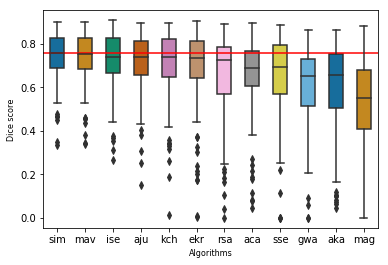

In [59]:
# fig = plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
bplot = sb.boxplot(data=wt_ordered, 
                 width=0.5,
                 palette="colorblind")
#bplot.axes.set_title('DICE Scores for whole tumor', fontsize=16)
bplot.set_xlabel('Algorithms', fontsize=8)
bplot.set_ylabel('Dice score', fontsize=8)
#plot a horizontal line at the max mean location
bplot.hlines(np.max(data.median()), -100, 1000, colors='r')
#save the plot
bplot.figure.savefig('plots/'+met+'_fullplot_thresh3.png', format=form, dpi=res)

Text(0, 0.5, 'Dice score')

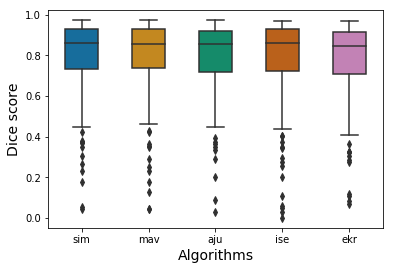

In [37]:
results = np.split(wt_ordered, [5], axis=1)
bplot1 = sb.boxplot(data=results[0], 
                 width=0.5,
                 palette="colorblind")
#bplot.axes.set_title('DICE Scores for whole tumor', fontsize=16)
bplot1.set_xlabel('Algorithms', fontsize=14)
bplot1.set_ylabel('Dice score', fontsize=14)

Text(0, 0.5, 'Dice score')

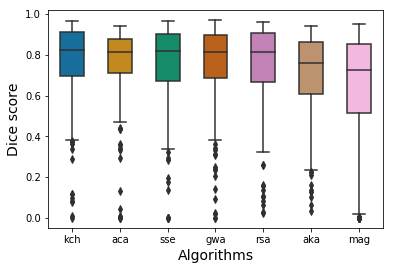

In [38]:
bplot2 = sb.boxplot(data=results[1], 
                 width=0.5,
                 palette="colorblind")
#bplot.axes.set_title('DICE Scores for whole tumor', fontsize=16)
bplot2.set_xlabel('Algorithms', fontsize=14)
bplot2.set_ylabel('Dice score', fontsize=14)

In [65]:
#save all of it
#bplot1.figure.savefig(met+'_boxplot1.png', format=form, dpi=res)
#bplot2.figure.savefig(met+'_boxplot2.png', format=form, dpi=res)
cl.savefig('clustermap.png', format=form, dpi=res)

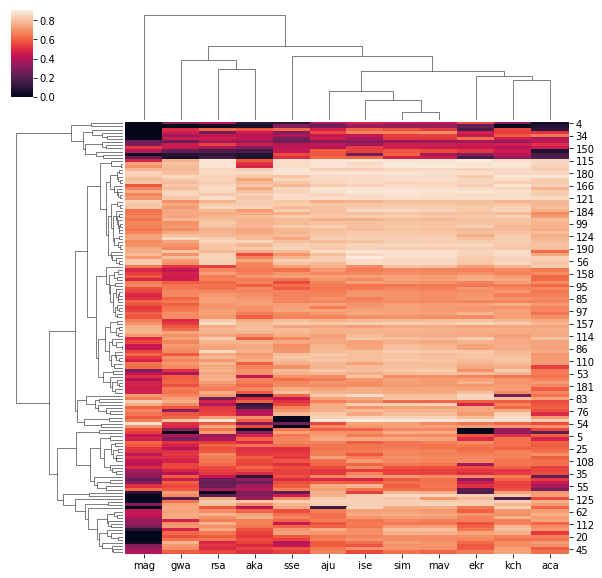

In [66]:
cl = sb.clustermap(wt_ordered, method='complete')

## Compound table for DICE

In [ ]:
data = pandas.read_csv('wt_dice_scores.csv')
wt_scores = preprocessor(data, 'whole')
tc_scores = preprocessor(pandas.read_csv('tc_dice_scores.csv'), 'core')
at_scores = preprocessor(pandas.read_csv('at_dice_scores.csv'), 'active')
wt_scores.describe()

In [ ]:
wt_m = wt_scores.median()
tc_m = tc_scores.median()
at_m = at_scores.median()
bobby = pandas.concat([wt_m, tc_m, at_m], axis=1, sort=True)
newkidz = {
    0 : 'WT',
    1 : 'TC',
    2 : 'AT'
}
bobby = bobby.rename(columns=newkidz)
bobby = bobby.round(decimals=3)*100
bobby.to_csv('tables/concisedice.csv')

## Specificity and Sensitivity Plotting

In [ ]:
# load data 
wt_spec = preprocessor(pandas.read_csv('specificity/wt_scores.csv'), 'wt-spec')
tc_spec = preprocessor(pandas.read_csv('specificity/tc_scores.csv'), 'tc-spec')
at_spec = preprocessor(pandas.read_csv('specificity/at_scores.csv'), 'at-spec')

wt_sens = preprocessor(pandas.read_csv('sensitivity/wt_scores.csv'), 'wt-sens')
tc_sens = preprocessor(pandas.read_csv('sensitivity/tc_scores.csv'), 'tc-sens')
at_sens = preprocessor(pandas.read_csv('sensitivity/at_scores.csv'), 'at-sens')


In [ ]:
wt_spec.describe()

In [ ]:
wt_sens.describe()

In [ ]:
# create Series for mean of specificity and sensitivity
wtsp_m = wt_spec.mean().round(decimals=3)
wtse_m = wt_sens.mean().round(decimals=3)
wtse_m

In [ ]:
# assemble Series to a single dataframe and rename the columns
wt_plt = pandas.concat([wtsp_m, wtse_m], axis=1, sort=True)
wt_plt = wt_plt.rename({0: 'Specificity', 1:'Sensitivity'}, axis=1)
# define some colors for the plots
colors = ['red','green','blue', 'aqua','gold','fuchsia', 'indigo','lavender','orange', 'sienna','teal','plum']
# plot sensitivity vs specificity 
ax = wt_plt.plot.scatter(x=0, y=1, c=colors, marker='s')
for i, txt in enumerate(wt_plt.index):
    ax.annotate(txt, (wt_plt.Specificity.iat[i],wt_plt.Sensitivity.iat[i]))
ax.grid(True)
ax.set_title('Whole Tumor Specificity vs Sensitivity')
ax.figure.savefig('wt_sesp.png', format=form, dpi=res)
#ax.annotate('aca', wt_plt[0][0], wt_plt[1][0])

In [ ]:
tcsp_m = tc_spec.mean().round(decimals=3)
tcse_m = tc_sens.mean().round(decimals=3)
tc_plt = pandas.concat([tcsp_m, tcse_m], axis=1, sort=True)
tc_plt = tc_plt.rename({0: 'Specificity', 1:'Sensitivity'}, axis=1)
colors = ['red','green','blue', 'aqua','gold','fuchsia', 'indigo','lavender','orange', 'sienna','teal','plum']
ax = tc_plt.plot.scatter(x=0, y=1, c=colors, marker='s')
for i, txt in enumerate(tc_plt.index):
    ax.annotate(txt, (tc_plt.Specificity.iat[i],tc_plt.Sensitivity.iat[i]))
ax.grid(True)
ax.set_title('Tumor Core Specificity vs Sensitivity')
ax.figure.savefig('tc_sesp.png', format=form, dpi=res)

In [ ]:
atsp_m = at_spec.mean().round(decimals=3)
atse_m = at_sens.mean().round(decimals=3)
at_plt = pandas.concat([atsp_m, atse_m], axis=1, sort=True)
at_plt = at_plt.rename({0: 'Specificity', 1:'Sensitivity'}, axis=1)
colors = ['red','green','blue', 'aqua','gold','fuchsia', 'indigo','lavender','orange', 'sienna','teal','plum']
ax = at_plt.plot.scatter(x=0, y=1, c=colors, marker='s')
for i, txt in enumerate(at_plt.index):
    ax.annotate(txt, (at_plt.Specificity.iat[i],at_plt.Sensitivity.iat[i]))
ax.grid(True)
ax.set_title('Active Tumor Specificity vs Sensitivity')
ax.figure.savefig('at_sesp.png', format=form, dpi=res)

In [ ]:
#once again but with MEDIAN 
atsp_m = at_spec.median().round(decimals=3)
atse_m = at_sens.median().round(decimals=3)
at_plt = pandas.concat([atsp_m, atse_m], axis=1, sort=True)
at_plt = at_plt.rename({0: 'Specificity', 1:'Sensitivity'}, axis=1)
colors = ['red','green','blue', 'aqua','gold','fuchsia', 'indigo','lavender','orange', 'sienna','teal','plum']
ax = at_plt.plot.scatter(x=0, y=1, c=colors, marker='s')
for i, txt in enumerate(at_plt.index):
    ax.annotate(txt, (at_plt.Specificity.iat[i],at_plt.Sensitivity.iat[i]))
ax.grid(True)
ax.set_title('Active Tumor Specificity vs Sensitivity')

In [ ]:
sens = at_plt.plot(y='Sensitivity', kind='bar')